## **Dataset**

In [2]:
from datasets import load_dataset

ds = load_dataset("wanhin/naruto-captions", split="train")

In [3]:
# get only 100 random samples
ds = ds.shuffle(seed=42).select(range(100))

In [4]:
import torch
from transformers import CLIPTextModel, CLIPTokenizer
device = torch.device(
    "cuda" if torch.cuda.is_available() else "cpu"
)
text_encoder = CLIPTextModel.from_pretrained("openai/clip-vit-base-patch16").to(device)
text_encoder.eval()
tokenizer = CLIPTokenizer.from_pretrained("openai/clip-vit-base-patch16")

c:\Users\Admin\miniconda3\envs\tf-gpu\lib\site-packages\transformers\tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [5]:
# Load Stable Diffusion VAE
from diffusers import AutoencoderKL
VAE_id = "stabilityai/sdxl-vae"
vae = AutoencoderKL.from_pretrained(VAE_id).to(device)
vae.requires_grad_(False)
vae.eval()

AutoencoderKL(
  (encoder): Encoder(
    (conv_in): Conv2d(3, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (down_blocks): ModuleList(
      (0): DownEncoderBlock2D(
        (resnets): ModuleList(
          (0-1): 2 x ResnetBlock2D(
            (norm1): GroupNorm(32, 128, eps=1e-06, affine=True)
            (conv1): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
            (norm2): GroupNorm(32, 128, eps=1e-06, affine=True)
            (dropout): Dropout(p=0.0, inplace=False)
            (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
            (nonlinearity): SiLU()
          )
        )
        (downsamplers): ModuleList(
          (0): Downsample2D(
            (conv): Conv2d(128, 128, kernel_size=(3, 3), stride=(2, 2))
          )
        )
      )
      (1): DownEncoderBlock2D(
        (resnets): ModuleList(
          (0): ResnetBlock2D(
            (norm1): GroupNorm(32, 128, eps=1e-06, affine=True)
            (c

torch.Size([256, 256, 3])


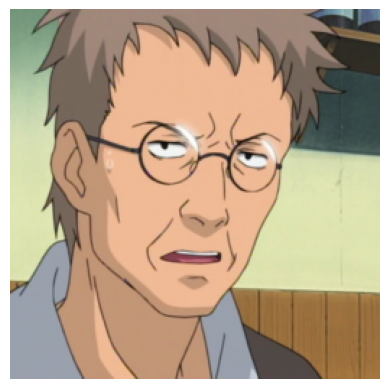

In [6]:
import torch
from torchvision import transforms
import matplotlib.pyplot as plt
import numpy as np
import torchvision.transforms.functional as F

image = ds[0]["image"]
image = image.convert("RGB")
transform = transforms.Compose(
            [transforms.Resize((256, 256)), transforms.ToTensor()]
        )
image = transform(image).unsqueeze(0)
image = np.transpose(image, (0, 2, 3, 1))
image = np.squeeze(image)
print(image.shape)
plt.imshow(image)
plt.axis("off")
plt.show()

torch.Size([1, 4, 32, 32])
torch.Size([1, 3, 256, 256])
(256, 256, 3)


c:\Users\Admin\miniconda3\envs\tf-gpu\lib\site-packages\diffusers\models\attention_processor.py:3313: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:555.)
  hidden_states = F.scaled_dot_product_attention(


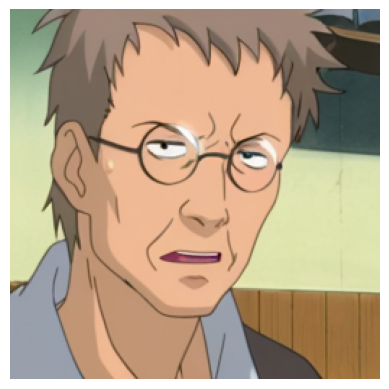

In [7]:
# Input a sample to get the latents
def tensor_to_image(tensor):
    return F.to_pil_image(tensor.clamp(0, 1))

image = ds[0]["image"]
image = image.convert("RGB")
transform = transforms.Compose(
            [transforms.Resize((256, 256)), transforms.ToTensor()]
        )
image = transform(image).unsqueeze(0).to(device)
with torch.no_grad():
    image = vae.encode(image).latent_dist.sample()
    print(image.shape)
    image = vae.decode(image).sample
    # tensor to pil image
    print(image.shape)
    image = tensor_to_image(image[0])
image = np.array(image)
print(image.shape)
plt.imshow(image)
plt.axis("off")
plt.show()


In [8]:
ds["text"][0]

'a man with glasses and a shirt on'

In [8]:
# ds["image"][0]

In [9]:
# ds["image"][0].save("text_to_image.png", format="PNG")

In [9]:
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

class CFMDataset(Dataset):
    def __init__(self, dataset, text_encoder, tokenizer, device):
        self.dataset = dataset
        self.transform = transforms.Compose(
            [transforms.Resize((256, 256)), transforms.ToTensor()]
            
        )
        self.text_encoder = text_encoder
        self.tokenizer = tokenizer
        self.device = device
        self.images = dataset["image"]
        self.captions = dataset["text"]
        self.cache = {}

    def get_embed(self, caption):
        inputs = self.tokenizer(
            caption,
            truncation=True,
            padding=True,
            return_tensors="pt"
        ).to(self.device)
        self.text_encoder.eval()
        with torch.no_grad():
            # Use mean pooling instead of just the first token
            text_features = self.text_encoder(**inputs).last_hidden_state
            # Mean pooling
            text_features = text_features.mean(dim=1)
        return text_features.squeeze(0)

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        if idx in self.cache:
            return self.cache[idx]

        transformed_image = self.transform(self.images[idx])
        transformed_latent_image = transformed_image.unsqueeze(0).to(self.device)
        with torch.no_grad():
            latent_image = vae.encode(transformed_latent_image).latent_dist.sample().squeeze(0)
        caption = self.captions[idx]
        caption_embedding = self.get_embed(caption)

        item = {
            "image": transformed_image,
            "latent_image": latent_image,
            "caption": caption,
            "caption_embedding": caption_embedding,
        }

        self.cache[idx] = item
        return item

In [10]:
train_ds = CFMDataset(ds, text_encoder, tokenizer, device)
train_loader = DataLoader(train_ds, batch_size=20, shuffle=True)

## **Model**

In [11]:
import math
import torch.nn as nn
from torchcfm.models.unet import UNetModel

def timestep_embedding(timesteps, dim, max_period=10000):
    """Create sinusoidal timestep embeddings.

    :param timesteps: a 1-D Tensor of N indices, one per batch element. These may be fractional.
    :param dim: the dimension of the output.
    :param max_period: controls the minimum frequency of the embeddings.
    :return: an [N x dim] Tensor of positional embeddings.
    """
    half = dim // 2
    freqs = torch.exp(
        -math.log(max_period)
        * torch.arange(start=0, end=half, dtype=torch.float32, device=timesteps.device)
        / half
    )
    args = timesteps[:, None].float() * freqs[None]
    embedding = torch.cat([torch.cos(args), torch.sin(args)], dim=-1)
    if dim % 2:
        embedding = torch.cat([embedding, torch.zeros_like(embedding[:, :1])], dim=-1)
    return embedding

class UNetModelWithTextEmbedding(UNetModel):
    def __init__(self, dim, num_channels, num_res_blocks, embedding_dim, *args, **kwargs):
        super().__init__(dim, num_channels, num_res_blocks, *args, **kwargs)

        self.embedding_layer = nn.Linear(embedding_dim, num_channels*4)
        self.fc = nn.Linear(num_channels*8, num_channels*4)

    def forward(self, t, x, text_embeddings=None):
        """Apply the model to an input batch, incorporating text embeddings."""
        timesteps = t

        while timesteps.dim() > 1:
            timesteps = timesteps[:, 0]
        if timesteps.dim() == 0:
            timesteps = timesteps.repeat(x.shape[0])

        hs = []
        emb = self.time_embed(
            timestep_embedding(timesteps, self.model_channels)
        )

        if text_embeddings is not None:
            text_embedded = self.embedding_layer(text_embeddings)
            emb = torch.cat([emb, text_embedded], dim=1) # 128*2
            emb = self.fc(emb)

        h = x.type(self.dtype)
        for module in self.input_blocks:
            h = module(h, emb)
            hs.append(h)
        h = self.middle_block(h, emb)
        for module in self.output_blocks:
            h = torch.cat([h, hs.pop()], dim=1)
            h = module(h, emb)
        h = h.type(x.dtype)
        return self.out(h)

## **Training**

In [12]:
model = UNetModelWithTextEmbedding(
    dim=(4, 32, 32), num_channels=64, num_res_blocks=1, embedding_dim=512, dropout=0.05, num_heads=4
).to(device)
optimizer = torch.optim.AdamW(model.parameters())

In [ ]:
from tqdm import tqdm

n_epochs = 10000
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=n_epochs)

for epoch in tqdm(range(n_epochs)):
    losses = []
    for batch in train_loader:
        optimizer.zero_grad()
        x1_latent = batch["latent_image"].to(device)
        text_embeddings = batch["caption_embedding"].to(device)

        x0 = torch.randn_like(x1_latent).to(device)

        t = torch.rand(x0.shape[0], 1, 1, 1).to(device)

        xt = t * x1_latent + (1 - t) * x0
        ut = x1_latent - x0

        t = t.squeeze()

        vt = model(t, xt, text_embeddings=text_embeddings)

        loss = torch.mean(((vt - ut) ** 2))

        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        losses.append(loss.item())

    avg_loss = sum(losses) / len(losses)
    if (epoch + 1) % 100 == 0:
        print(f"Epoch [{epoch+1}/{n_epochs}], Loss: {avg_loss:.4f}")

In [13]:
torch.cuda.empty_cache()

In [28]:
torch.save(model.state_dict(), "./model/Text_to_Image_LCFM.pth")

In [34]:
model.load_state_dict(torch.load("./model/Text_to_Image_LCFM.pth", weights_only=True))

<All keys matched successfully>

## **Inference**

# Batch of sample test

In [219]:
model.eval()
def euler_method(model, text_embedding, t_steps, dt, noise):
    y = noise
    y_values = []
    with torch.no_grad():
        for t in t_steps:
            dy = model(
                t.to(device), y,
                text_embeddings=text_embedding
            )
            y = y + dy * dt
            y_values.append(y)
    torch.cuda.empty_cache()
    return torch.stack(y_values)

# Initial random image and class (optional)
sample = next(iter(train_loader))
image = sample["latent_image"].to(device)
print(image.shape)
text_embeddings = sample["caption_embedding"].to(device)
noise = torch.randn_like(image, device=device)
# Time parameters
t_steps = torch.linspace(0, 1, 50, device=device)
dt = t_steps[1] - t_steps[0]

# Solve the ODE using Euler method
results = euler_method(model, text_embeddings, t_steps, dt, noise)

torch.Size([20, 4, 32, 32])


In [204]:
results.shape

torch.Size([50, 20, 4, 32, 32])

# decode the latent z

In [233]:
def latent_to_image(latent_tensors, num_sample_from_batch=1, timesteps_to_sample=9):
    """
    Decode latent tensors to images using loop to ensure accuracy.
    
    Args:
        latent_tensors: torch.Tensor with shape [T, B, C, H, W]
        num_sample_from_batch: number of samples to randomly choose from batch dimension
        timesteps_to_sample: number of timesteps to select evenly from the total timesteps
    
    Returns:
        results: torch.Tensor with shape [timesteps_to_sample, num_sample_from_batch, C', H', W']
    """
    T, B, C, H, W = latent_tensors.shape

    # 1. Chọn đều các bước thời gian
    timestep_indices = torch.linspace(0, T - 1, timesteps_to_sample).long()  # [9]
    latent_tensors = latent_tensors[timestep_indices]  # [selected_T, B, C, H, W]

    # 2. Chọn ngẫu nhiên từ batch
    random_indices = torch.randint(0, B, (num_sample_from_batch,)) # does have duplicates
    latent_tensors = latent_tensors[:, random_indices, :, :, :]  # [T', B', C, H, W]

    # 3. Decode từng ảnh
    decoded_list = []
    for t in range(timesteps_to_sample):
        frame_list = []
        for b in range(num_sample_from_batch):
            latent = latent_tensors[t, b]  # [C, H, W]
            decoded = vae.decode(latent.unsqueeze(0)).sample  # [1, C', H', W']
            torch.cuda.empty_cache()
            frame_list.append(decoded.squeeze(0))      # [C', H', W']
        decoded_list.append(torch.stack(frame_list))    # [B', C', H', W']

    # 4. Stack lại thành [T', B', C', H', W']
    results = torch.stack(decoded_list)  # [T', B', C', H', W']
    return results

decoded_images = latent_to_image(results, num_sample_from_batch=10, timesteps_to_sample=10)
decoded_images.shape

torch.Size([10, 10, 3, 256, 256])

# Single desired sample test

In [ ]:
input_prompt = "a man with glasses and shirt on"
text_embedding = train_ds.get_embed(input_prompt).unsqueeze(0)
noise = torch.randn((1, 4, 32, 32), device=device)
results = euler_method(model, text_embedding, t_steps, dt, noise)
decoded_images = latent_to_image(results, num_sample_from_batch=1, timesteps_to_sample=10)

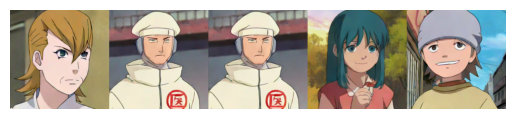

In [240]:
import matplotlib.pyplot as plt
from torchvision.utils import make_grid
import torchvision.transforms.functional as F

grid = make_grid(
    decoded_images[-1, :5], padding=0, nrow=10
)
def tensor_to_image(tensor):
    return F.to_pil_image(tensor.clamp(0, 1))

img = tensor_to_image(grid)
plt.axis("off")
plt.imshow(img)
plt.show()

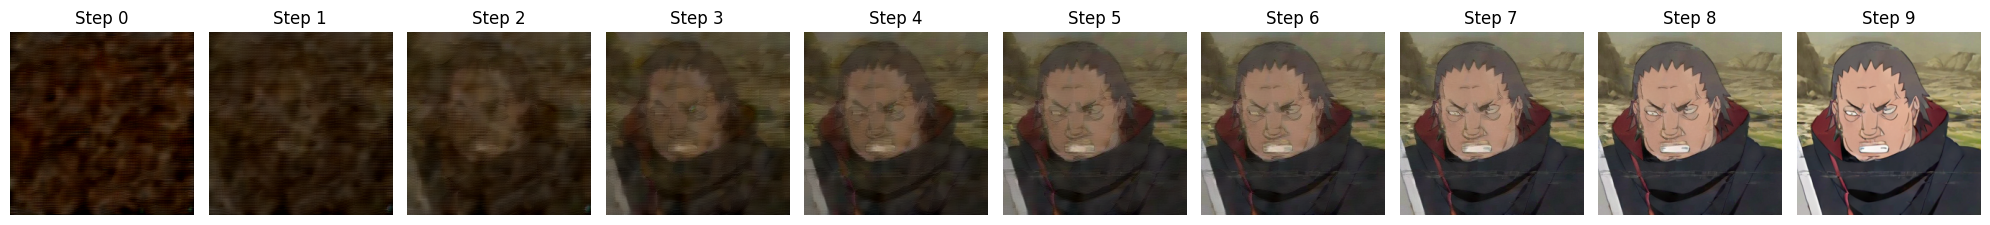

✅ Saved GIF to 'sample_5.gif'


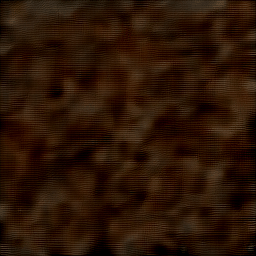

In [238]:
from IPython.display import display, Image as IPyImage

def show_and_save_sampling_progress(results, sample_idx=0, num_steps=9, save_path="sampling.gif", duration=300):
    """
    Hiển thị quá trình sampling (dạng ảnh) và đồng thời lưu thành file GIF.

    Args:
        traj (Tensor): Tensor 5D (T, B, C, H, W)
        sample_idx (int): Index của sample trong batch
        num_steps (int): Số bước sampling để hiển thị và lưu gif
        save_path (str): Đường dẫn file gif muốn lưu
        duration (int): Thời gian mỗi frame (milliseconds)
    """
    T = results.shape[0]
    assert num_steps <= T, "Số bước cần hiển thị phải nhỏ hơn hoặc bằng tổng số bước."

    # Lấy các bước cách đều từ 0 đến T-1
    indices = torch.linspace(0, T - 1, num_steps).long()

    fig, axes = plt.subplots(1, num_steps, figsize=(num_steps * 2, 6))
    frames = []

    for i, idx in enumerate(indices):
        if results.shape[1] == 1:
            # Nếu batch size là 1, chỉ cần lấy ảnh đầu tiên
            sample_idx = 0
        img_tensor = results[idx, sample_idx]  # (C, H, W)
        pil_img = tensor_to_image(img_tensor.cpu())
        frames.append(pil_img)

        # Hiển thị bằng matplotlib
        axes[i].imshow(pil_img)
        axes[i].axis("off")
        axes[i].set_title(f"Step {(idx).item()}")

    plt.tight_layout()
    plt.show()

    # Save GIF
    frames[0].save(
        save_path,
        save_all=True,
        append_images=frames[1:],
        duration=duration,
        loop=0
    )
    print(f"✅ Saved GIF to '{save_path}'")

    display(IPyImage(filename=save_path))

sample_idx = 5
show_and_save_sampling_progress(decoded_images, sample_idx=sample_idx, num_steps=10, save_path=f"sample_{sample_idx}.gif")